# Data exploration

In [ ]:
import os

path2train="/kaggle/input/automated-measurement-of-fetal-head-circumference/training_set/training_set/"

imgsList=[pp for pp in os.listdir(path2train) if "Annotation" not in pp and "HC" in pp]
anntsList=[pp for pp in os.listdir(path2train) if "Annotation" in pp]
print("number of images:", len(imgsList))
print("number of annotations:", len(anntsList))

number of images: 999
number of annotations: 999


In [ ]:
import numpy as np

np.random.seed(2023)
rndImgs=np.random.choice(imgsList,4)
rndImgs

array(['384_HC.png', '884_2HC.png', '265_HC.png', '715_HC.png'],
      dtype='<U11')

In [ ]:
import matplotlib.pylab as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries

def show_img_mask(img, mask):
    img_mask=mark_boundaries(np.array(img),
                             np.array(mask),
                             outline_color=(0,1,0),
                             color=(0,1,0))
    plt.imshow(img_mask)

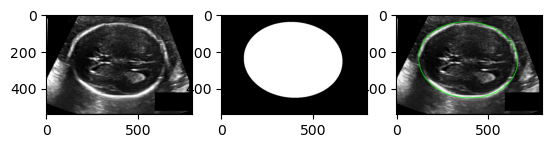

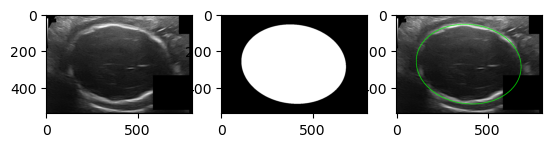

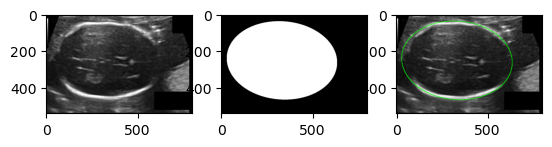

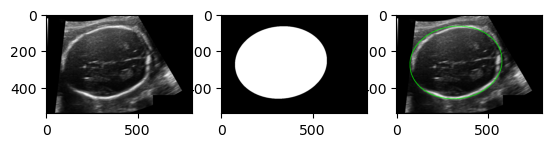

In [ ]:
for fn in rndImgs:
    path2img = os.path.join(path2train, fn)
    path2annt= path2img.replace(".png", "_Annotation.png")
    img = Image.open(path2img)
    annt_edges = Image.open(path2annt)
    mask = ndi.binary_fill_holes(annt_edges)
    
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    
    plt.subplot(1, 3, 3)
    show_img_mask(img, mask)

# Data augmentation

In [ ]:
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Compose,
    Resize
)

h,w=128,192
transform_train = Compose([Resize(h,w),
                           HorizontalFlip(p=0.5),
                           VerticalFlip(p=0.5),
                          ])

transform_val = Resize(h,w)

# Creating the datasets

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms.functional import (
    to_tensor,
    to_pil_image
)

class fetal_dataset(Dataset):
    def __init__(self, path2data, transform=None):
        imgsList=[pp for pp in os.listdir(path2data) if "Annotation" not in pp and "HC" in pp]
        anntsList=[pp for pp in os.listdir(path2train) if "Annotation" in pp]
        self.path2imgs = [os.path.join(path2data, fn) for fn in imgsList]
        self.path2annts= [p2i.replace(".png", "_Annotation.png") for p2i in self.path2imgs]
        self.transform = transform
        
    def __len__(self):
        return len(self.path2imgs)
    
    def __getitem__(self, idx):
        path2img = self.path2imgs[idx]
        image = Image.open(path2img)
        path2annt = self.path2annts[idx]
        annt_edges = Image.open(path2annt)
        mask = ndi.binary_fill_holes(annt_edges)
        image= np.array(image)
        mask=mask.astype("uint8")
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        image=to_tensor(image)
        mask=255*to_tensor(mask)
        
        return image, mask

In [ ]:
fetal_ds1=fetal_dataset(path2train, transform=transform_train)
fetal_ds2=fetal_dataset(path2train, transform=transform_val)
print(len(fetal_ds1))
print(len(fetal_ds2))

999
999


In [ ]:
img,mask=fetal_ds1[0]
print(img.shape, img.type(), torch.max(img))
print(mask.shape, mask.type(), torch.max(mask))

torch.Size([1, 128, 192]) torch.FloatTensor tensor(0.9529)
torch.Size([1, 128, 192]) torch.FloatTensor tensor(1.)


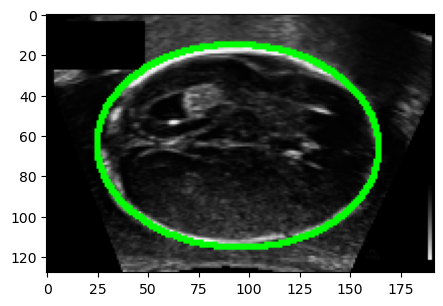

In [ ]:
plt.figure(figsize=(5,5))
show_img_mask(img[0], mask[0].byte())

In [ ]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=200, random_state=2023)

indices=range(len(fetal_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

799
----------
200


In [ ]:
from torch.utils.data import Subset

train_ds=Subset(fetal_ds1,train_index)
print(len(train_ds))

val_ds=Subset(fetal_ds2,val_index)
print(len(val_ds))

799
200


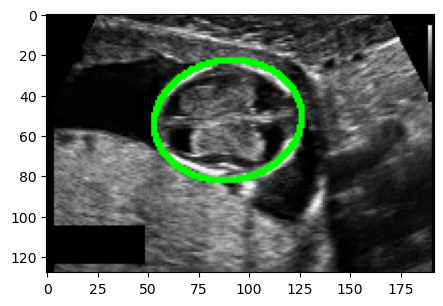

In [ ]:
plt.figure(figsize=(5,5))
for img,mask in train_ds:
    show_img_mask(img[0],mask[0].byte())
    break

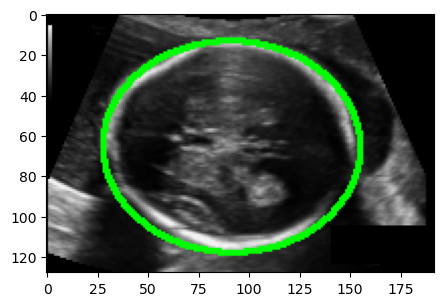

In [ ]:
plt.figure(figsize=(5,5))
for img,mask in val_ds:
    show_img_mask(img[0],mask[0].byte())
    break

In [ ]:
from torch.utils.data import DataLoader

train_batch_size = 8
val_batch_size = 16
train_dl = DataLoader(train_ds, batch_size=train_batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=val_batch_size, shuffle=False)

In [ ]:
for img_b, mask_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([8, 1, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32


In [ ]:
for img_b, mask_b in val_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([16, 1, 128, 192]) torch.float32
torch.Size([16, 1, 128, 192]) torch.float32


# Defining a custom model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CustomNet(nn.Module):
    def __init__(self, params):
        super(CustomNet, self).__init__()
        C_in, H_in, W_in=params["input_shape"]
        init_f=params["initial_filters"]
        num_outputs=params["num_outputs"]
        
        self.conv1 = nn.Conv2d(C_in, init_f,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f,kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f,kernel_size=3,stride=1,padding=1)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f,kernel_size=3,stride=1,padding=1)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f,kernel_size=3,stride=1,padding=1)
        
        self.upsample = nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True)
        
        self.conv_up1 = nn.Conv2d(16*init_f, 8*init_f,kernel_size=3,stride=1,padding=1)
        self.conv_up2 = nn.Conv2d(8*init_f, 4*init_f,kernel_size=3,stride=1,padding=1)
        self.conv_up3 = nn.Conv2d(4*init_f, 2*init_f,kernel_size=3,stride=1,padding=1)
        self.conv_up4 = nn.Conv2d(2*init_f, init_f,kernel_size=3,stride=1,padding=1)
        
        self.conv_out = nn.Conv2d(init_f, num_outputs,kernel_size=3,stride=1,padding=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, stride=2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, stride=2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, stride=2)
        
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, stride=2)
        
        x = F.relu(self.conv5(x))
        
        x = self.upsample(x)
        x = F.relu(self.conv_up1(x))
        
        x = self.upsample(x)
        x = F.relu(self.conv_up2(x))
        
        x = self.upsample(x)
        x = F.relu(self.conv_up3(x))
        
        x = self.upsample(x)
        x = F.relu(self.conv_up4(x))
        
        x = self.conv_out(x)
        
        return x

In [ ]:
params_model={
    "input_shape": (1,h,w),
    "initial_filters": 16,
    "num_outputs": 1
}
model = CustomNet(params_model)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)

In [ ]:
print(model)

CustomNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [ ]:
from torchinfo import summary

summary(model, input_size=(train_batch_size, 1, h, w), device=device.type)

Layer (type:depth-idx)                   Output Shape              Param #
CustomNet                                [8, 1, 128, 192]          --
├─Conv2d: 1-1                            [8, 16, 128, 192]         160
├─Conv2d: 1-2                            [8, 32, 64, 96]           4,640
├─Conv2d: 1-3                            [8, 64, 32, 48]           18,496
├─Conv2d: 1-4                            [8, 128, 16, 24]          73,856
├─Conv2d: 1-5                            [8, 256, 8, 12]           295,168
├─Upsample: 1-6                          [8, 256, 16, 24]          --
├─Conv2d: 1-7                            [8, 128, 16, 24]          295,040
├─Upsample: 1-8                          [8, 128, 32, 48]          --
├─Conv2d: 1-9                            [8, 64, 32, 48]           73,792
├─Upsample: 1-10                         [8, 64, 64, 96]           --
├─Conv2d: 1-11                           [8, 32, 64, 96]           18,464
├─Upsample: 1-12                         [8, 32, 128, 1

# Defining the loss function and optimizer

In [ ]:
def dice_loss(pred, target, smooth = 1e-5): # sigmoid has to be applied to pred prior to passing it
    intersection = (pred * target).sum(dim=(2,3))
    union_plus_intersection = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = 2.0 * (intersection + smooth) / (union_plus_intersection + smooth)
    loss = 1.0 - dice
    
    return loss.sum(), dice.sum() # division for average loss and dice are done later

In [ ]:
def loss_func(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target, reduction='sum')
    pred = torch.sigmoid(pred)
    dlv, _ = dice_loss(pred, target)
    loss = bce + dlv
    
    return loss

In [ ]:
def metrics_batch(pred, target):
    pred = torch.sigmoid(pred)
    _, metric = dice_loss(pred, target)
    
    return metric

In [ ]:
def loss_batch(loss_func, pred, target, opt=None):
    loss = loss_func(pred, target)
    pred = torch.sigmoid(pred)
    _, metric_b = dice_loss(pred, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    return loss.item(), metric_b.item()

In [ ]:
from torch import optim

learning_rate = 1e-3
opt = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=1, verbose=True)

# Training the model

In [ ]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)
    
    for xb, yb in dataset_dl: # xb == img_b && yb == mask_b
        xb=xb.type(torch.float32).to(device)
        yb=yb.type(torch.float32).to(device)
        output=model(xb)
        loss_b, metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b # division for average loss is done later
        
        if metric_b is not None:
            running_metric += metric_b # division for average dice is done later
        if sanity_check is True:
            break
    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data) # division for average loss and dice
    
    return loss, metric

In [ ]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [ ]:
import copy

def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": []
    }
    metric_history={
        "train": [],
        "val": []
    }
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch + 1, num_epochs, current_lr))
        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl,sanity_check)
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
        print("train loss: %.6f, dice: %.2f %%" %(train_loss,100*train_metric))
        print("val loss: %.6f, dice: %.2f %%" %(val_loss,100*val_metric))
        print("-"*10)
    
    model.load_state_dict(best_model_wts)
    
    return model, loss_history, metric_history

In [ ]:
path2models= "/kaggle/working/models/"
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
params_train={
    "num_epochs": 20,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models + "weights.pt"
}

In [ ]:
model, loss_hist, metric_hist = train_val(model,params_train)

Epoch 1/20, current lr=0.001
Copied best model weights!
train loss: 8987.591115, dice: 53.75 %
val loss: 7000.646523, dice: 71.73 %
----------
Epoch 2/20, current lr=0.001
Copied best model weights!
train loss: 5893.356508, dice: 72.41 %
val loss: 4805.918271, dice: 77.67 %
----------
Epoch 3/20, current lr=0.001
Copied best model weights!
train loss: 3957.377361, dice: 80.18 %
val loss: 4018.174893, dice: 80.15 %
----------
Epoch 4/20, current lr=0.001
Copied best model weights!
train loss: 3206.086584, dice: 83.73 %
val loss: 3080.968232, dice: 84.47 %
----------
Epoch 5/20, current lr=0.001
Copied best model weights!
train loss: 2538.067415, dice: 87.17 %
val loss: 2552.533281, dice: 87.57 %
----------
Epoch 6/20, current lr=0.001
Copied best model weights!
train loss: 2023.423635, dice: 89.79 %
val loss: 2239.035420, dice: 89.67 %
----------
Epoch 7/20, current lr=0.001
Copied best model weights!
train loss: 1991.723024, dice: 90.18 %
val loss: 2143.804878, dice: 89.64 %
----------

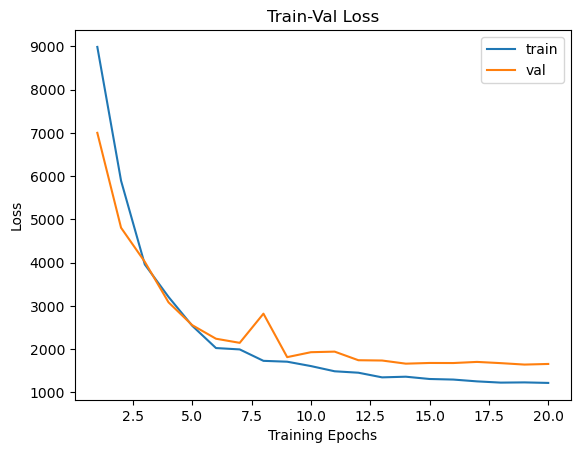

In [ ]:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

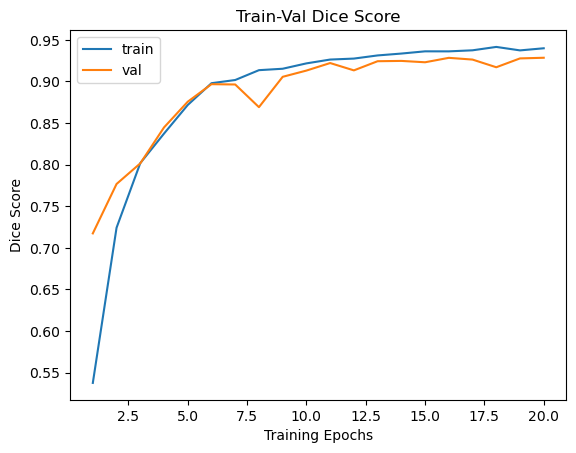

In [ ]:
plt.title("Train-Val Dice Score")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Dice Score")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# Deploying the model

In [ ]:
path2test = "/kaggle/input/automated-measurement-of-fetal-head-circumference/test_set/test_set/"
imgsList=[pp for pp in os.listdir(path2test) if "Annotation" not in pp and "HC" in pp]
print("number of images:", len(imgsList))

number of images: 335


In [ ]:
np.random.seed(2023)
rndImgs=np.random.choice(imgsList,4)
rndImgs

array(['323_HC.png', '127_HC.png', '205_HC.png', '137_HC.png'],
      dtype='<U11')

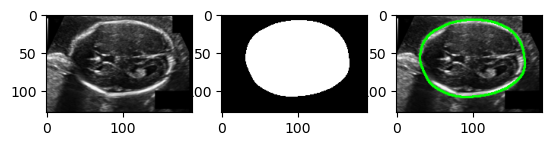

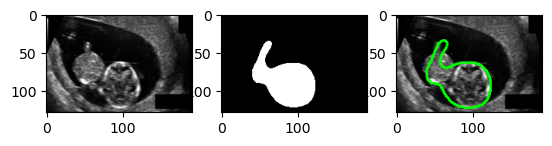

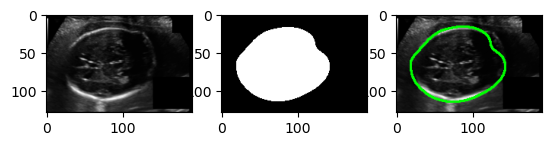

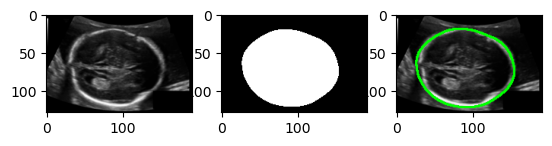

In [ ]:
model.eval()
for fn in rndImgs:
    path2img = os.path.join(path2test, fn)
    img = Image.open(path2img)
    img = img.resize((w,h))
    img_t = to_tensor(img).unsqueeze(0).to(device)
    pred = model(img_t)
    pred = torch.sigmoid(pred)[0]
    mask_pred = (pred[0]>=0.5)
    
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask_pred.cpu(), cmap="gray")
    
    plt.subplot(1, 3, 3)
    show_img_mask(img, mask_pred.cpu())

# Defining the UNet model

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [ ]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [ ]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
model_unet = UNet(1, 1, True)

In [ ]:
model_unet=model_unet.to(device)

In [ ]:
print(model_unet)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [ ]:
summary(model_unet, input_size=(train_batch_size, 1, h, w), device=device.type)

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [8, 1, 128, 192]          --
├─DoubleConv: 1-1                             [8, 64, 128, 192]         --
│    └─Sequential: 2-1                        [8, 64, 128, 192]         --
│    │    └─Conv2d: 3-1                       [8, 64, 128, 192]         576
│    │    └─BatchNorm2d: 3-2                  [8, 64, 128, 192]         128
│    │    └─ReLU: 3-3                         [8, 64, 128, 192]         --
│    │    └─Conv2d: 3-4                       [8, 64, 128, 192]         36,864
│    │    └─BatchNorm2d: 3-5                  [8, 64, 128, 192]         128
│    │    └─ReLU: 3-6                         [8, 64, 128, 192]         --
├─Down: 1-2                                   [8, 128, 64, 96]          --
│    └─Sequential: 2-2                        [8, 128, 64, 96]          --
│    │    └─MaxPool2d: 3-7                    [8, 64, 64, 96]           --
│    │    └─D

# Defining the optimizer

In [ ]:
learning_rate_unet = 1e-3
opt_unet = optim.Adam(model_unet.parameters(), lr=learning_rate_unet)

In [ ]:
lr_scheduler_unet = ReduceLROnPlateau(opt_unet, mode='min', factor=0.5, patience=1, verbose=True)

# Training the model

In [ ]:
params_train_unet={
    "num_epochs": 10,
    "optimizer": opt_unet,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler_unet,
    "path2weights": path2models + "weights_unet.pt"
}

In [ ]:
model_unet, loss_hist_unet, metric_hist_unet = train_val(model_unet,params_train_unet)

Epoch 1/10, current lr=0.001
Copied best model weights!
train loss: 1727.677909, dice: 91.52 %
val loss: 2145.205928, dice: 91.90 %
----------
Epoch 2/10, current lr=0.001
Copied best model weights!
train loss: 1554.746396, dice: 92.56 %
val loss: 1632.378135, dice: 92.37 %
----------
Epoch 3/10, current lr=0.001
train loss: 1379.450111, dice: 93.32 %
val loss: 2000.104819, dice: 91.84 %
----------
Epoch 4/10, current lr=0.001
Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Loading best model weights!
train loss: 1403.659418, dice: 93.22 %
val loss: 1642.761636, dice: 93.01 %
----------
Epoch 5/10, current lr=0.0005
train loss: 1277.052573, dice: 93.97 %
val loss: 1693.126914, dice: 92.40 %
----------
Epoch 6/10, current lr=0.0005
Copied best model weights!
train loss: 1228.371646, dice: 94.14 %
val loss: 1616.164180, dice: 93.06 %
----------
Epoch 7/10, current lr=0.0005
train loss: 1187.712612, dice: 94.56 %
val loss: 1638.334302, dice: 93.48 %
----------
Epoch 8/10, cu

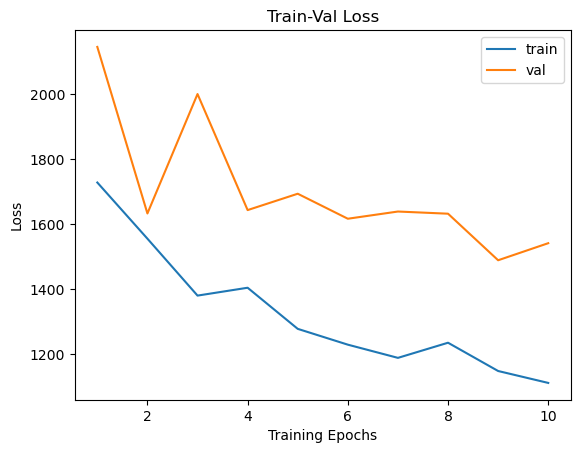

In [ ]:
num_epochs_unet=params_train_unet["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs_unet+1),loss_hist_unet["train"],label="train")
plt.plot(range(1,num_epochs_unet+1),loss_hist_unet["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

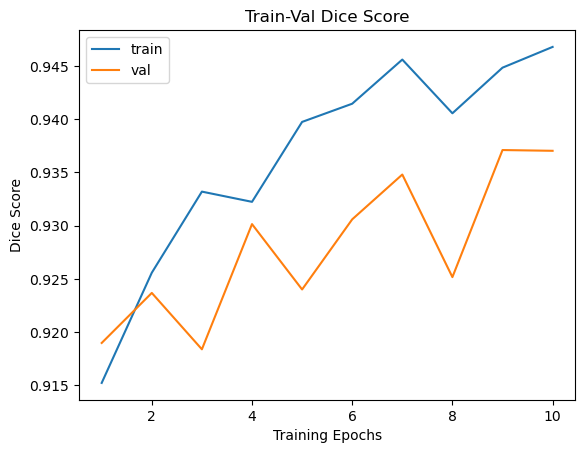

In [ ]:
plt.title("Train-Val Dice Score")
plt.plot(range(1,num_epochs_unet+1),metric_hist_unet["train"],label="train")
plt.plot(range(1,num_epochs_unet+1),metric_hist_unet["val"],label="val")
plt.ylabel("Dice Score")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# Deploying the model

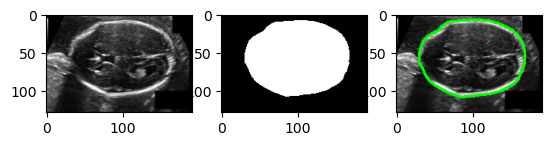

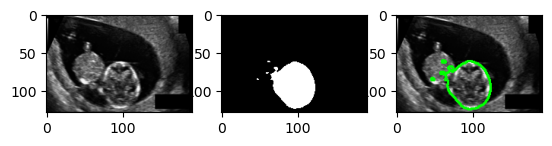

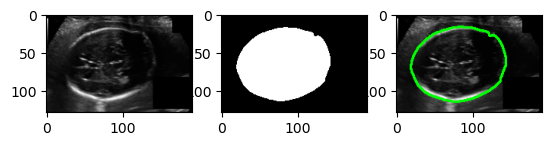

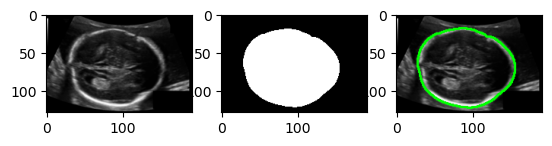

In [ ]:
model_unet.eval()
for fn in rndImgs:
    path2img = os.path.join(path2test, fn)
    img = Image.open(path2img)
    img = img.resize((w,h))
    img_t = to_tensor(img).unsqueeze(0).to(device)
    pred = model_unet(img_t)
    pred = torch.sigmoid(pred)[0]
    mask_pred = (pred[0]>=0.5)
    
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask_pred.cpu(), cmap="gray")
    
    plt.subplot(1, 3, 3)
    show_img_mask(img, mask_pred.cpu())

### Custom encoder-decoder model:
Validation dice score after 20 epochs: 92.85 %

### UNet model:
Validation dice score after 10 epochs: 93.70 %

### Comparison:
Here, the UNet model gives a better validation dice score even with a lower number of training epochs. The UNet model performs better.